<a href="https://colab.research.google.com/github/AlexLiang230410/nem-battery-arbitrage/blob/main/notebooks/01_baseline_arbitrage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Cell 0: clone the repo (if needed) and switch to project root

import os

repo_url = "https://github.com/AlexLiang230410/nem-battery-arbitrage.git"

# Only clone if the folder does not exist yet
if not os.path.exists("/content/nem-battery-arbitrage"):
    !git clone $repo_url

os.chdir("/content/nem-battery-arbitrage")
print("Current working directory:", os.getcwd())


Current working directory: /content/nem-battery-arbitrage


In [10]:
from battery_core import simulate_arbitrage, summarize_performance
from data_utils import load_price_range
import matplotlib.pyplot as plt
import pandas as pd

# User-configurable parameters

# Region for the AEMO PRICE_AND_DEMAND files
region = "VIC1"   # e.g. VIC1, NSW1, QLD1, SA1, TAS1

# Define the start and end month for data loading
start_year = 2024
start_month = 12    # 1-12
end_year = 2025
end_month = 11      # 1-12

# Time-step length in minutes (PRICE_AND_DEMAND uses 5-minute intervals)
dt_mins = 5

# Battery parameters
power_mw = 10       # Maximum charge/discharge power (MW)
energy_mwh = 20     # Energy capacity (MWh), e.g. 2-hour battery = 2 * power_mw

# Simple threshold strategy parameters
charge_threshold = 30    # Charge when price <= this value ($/MWh)
discharge_threshold = 70 # Discharge when price >= this value ($/MWh)

# Round-trip efficiency
efficiency = 0.85

# Parameters for visualization
visualization_year = 2025
visualization_month = 11 # 1-12: The month you want to visualize

data_dir = "data/aemo_price_and_demand"

In [11]:
# load real NEM price data for the selected region and period

price_df = load_price_range(
    region=region,
    start_year=start_year,
    start_month=start_month,
    end_year=end_year,
    end_month=end_month,
    data_dir=data_dir,    # "data/aemo_price_and_demand"
    # strict=True  # default; if some months are missing and you want to skip them, set strict=False
)

print("Loaded price data:")
print("  shape:", price_df.shape)
print("  index range:", price_df.index.min(), "→", price_df.index.max())
display(price_df.head())
display(price_df.tail())


Loaded price data:
  shape: (105120, 1)
  index range: 2024-12-01 00:05:00 → 2025-12-01 00:00:00


,price
SETTLEMENTDATE,
2024-12-01 00:05:00,91.84
2024-12-01 00:10:00,91.37
2024-12-01 00:15:00,95.07
2024-12-01 00:20:00,89.65
2024-12-01 00:25:00,90.03


,price
SETTLEMENTDATE,
2025-11-30 23:40:00,-3.7
2025-11-30 23:45:00,-3.7
2025-11-30 23:50:00,-3.7
2025-11-30 23:55:00,-3.7
2025-12-01 00:00:00,-3.7


In [12]:
# run baseline arbitrage simulation using the threshold strategy

result_df = simulate_arbitrage(
    price_df=price_df,
    dt_mins=dt_mins,
    power_mw=power_mw,
    energy_mwh=energy_mwh,
    charge_threshold=charge_threshold,
    discharge_threshold=discharge_threshold,
    efficiency=efficiency,
)

print("Simulation result:")
print("  shape:", result_df.shape)
display(result_df.head())


Simulation result:
  shape: (105120, 6)


,price,action,power_mw,soc_mwh,revenue,cumulative_revenue
SETTLEMENTDATE,,,,,,
2024-12-01 00:05:00,91.84,idle,0.0,0.0,0.0,0.0
2024-12-01 00:10:00,91.37,idle,0.0,0.0,0.0,0.0
2024-12-01 00:15:00,95.07,idle,0.0,0.0,0.0,0.0
2024-12-01 00:20:00,89.65,idle,0.0,0.0,0.0,0.0
2024-12-01 00:25:00,90.03,idle,0.0,0.0,0.0,0.0


In [13]:
# summarise performance of the baseline scenario

summary = summarize_performance(
    result_df=result_df,
    dt_mins=dt_mins,
    power_mw=power_mw,
    energy_mwh=energy_mwh,
    print_summary=True,  # print human-readable summary
)

print()
print("Summary dictionary (for further analysis or saving):")
summary


=== Battery Arbitrage Performance Summary ===
Power (MW):                10.00
Energy (MWh):              20.00
Total revenue (AUD):       778604.66
Discharged energy (MWh):   6784.99
Equivalent full cycles:    339.25
Discharge hours (h):       678.50

Summary dictionary (for further analysis or saving):


{'power_mw': 10.0,
 'energy_mwh': 20.0,
 'total_revenue': 778604.6581726682,
 'discharge_energy_mwh': 6784.994107950254,
 'equivalent_full_cycles': 339.2497053975127,
 'discharge_hours': 678.4994107950254}

In [14]:
# select a one-month window for detailed visualisation

vis_start = pd.Timestamp(
    year=visualization_year,
    month=visualization_month,
    day=1,
)
vis_end = vis_start + pd.DateOffset(months=1)

window_df = result_df.loc[vis_start:vis_end].copy()

print(f"Visualisation window: {vis_start} → {vis_end}")
print("Window shape:", window_df.shape)
display(window_df.head())


Visualisation window: 2025-11-01 00:00:00 → 2025-12-01 00:00:00
Window shape: (8641, 6)


,price,action,power_mw,soc_mwh,revenue,cumulative_revenue
SETTLEMENTDATE,,,,,,
2025-11-01 00:00:00,106.10,idle,0.0,0.0,0.0,732932.749269
2025-11-01 00:05:00,108.42,idle,0.0,0.0,0.0,732932.749269
2025-11-01 00:10:00,120.80,idle,0.0,0.0,0.0,732932.749269
2025-11-01 00:15:00,125.17,idle,0.0,0.0,0.0,732932.749269
2025-11-01 00:20:00,98.70,idle,0.0,0.0,0.0,732932.749269


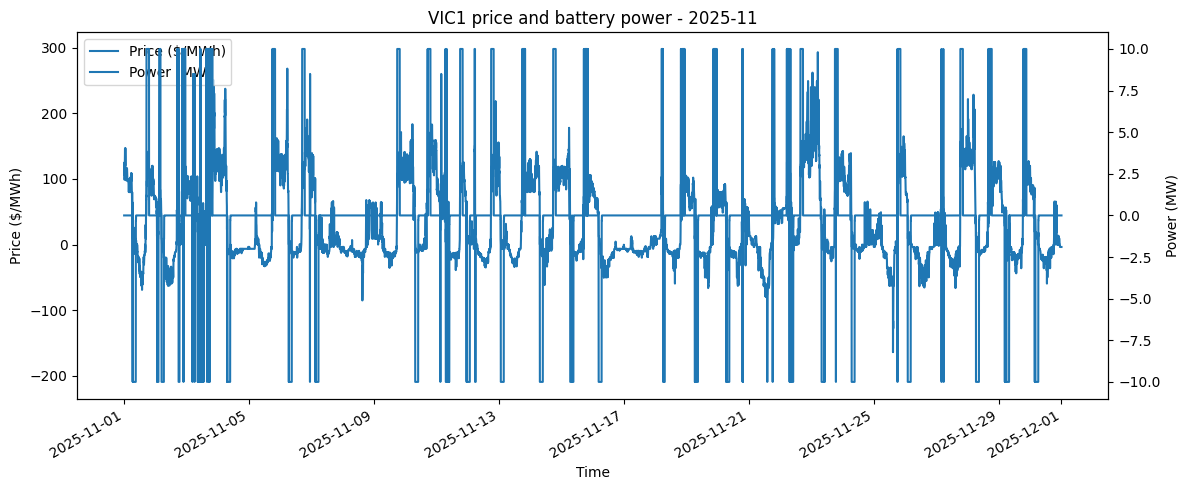

In [15]:
# plot price and battery power in the selected window

fig, ax1 = plt.subplots(figsize=(12, 5))

# Price on the left y-axis
ax1.plot(window_df.index, window_df["price"], label="Price ($/MWh)")
ax1.set_xlabel("Time")
ax1.set_ylabel("Price ($/MWh)")

# Power on the right y-axis
ax2 = ax1.twinx()
ax2.step(
    window_df.index,
    window_df["power_mw"],
    where="post",
    label="Power (MW)",
)
ax2.set_ylabel("Power (MW)")

ax1.set_title(
    f"{region} price and battery power - {visualization_year}-{visualization_month:02d}"
)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

fig.autofmt_xdate()
plt.tight_layout()
plt.show()


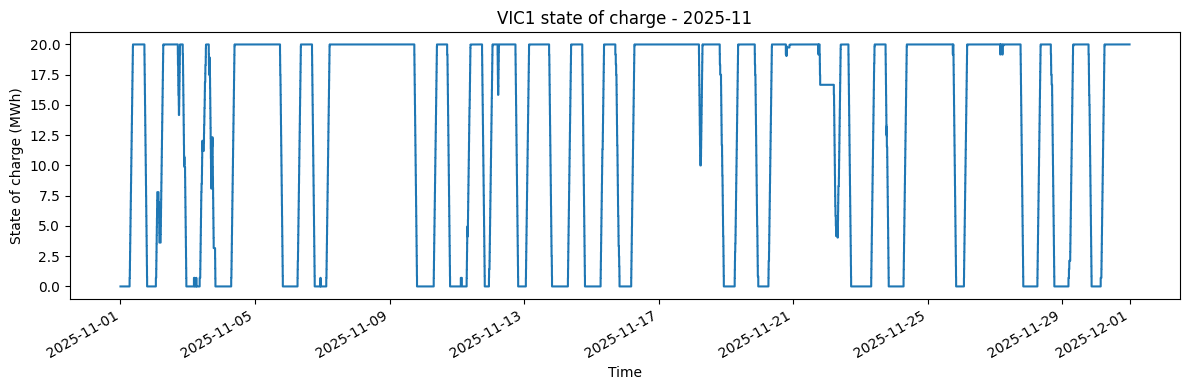

In [16]:
# plot state of charge (SOC) in the selected window

fig, ax = plt.subplots(figsize=(12, 4))

ax.step(
    window_df.index,
    window_df["soc_mwh"],
    where="post",
)
ax.set_xlabel("Time")
ax.set_ylabel("State of charge (MWh)")
ax.set_title(
    f"{region} state of charge - {visualization_year}-{visualization_month:02d}"
)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()


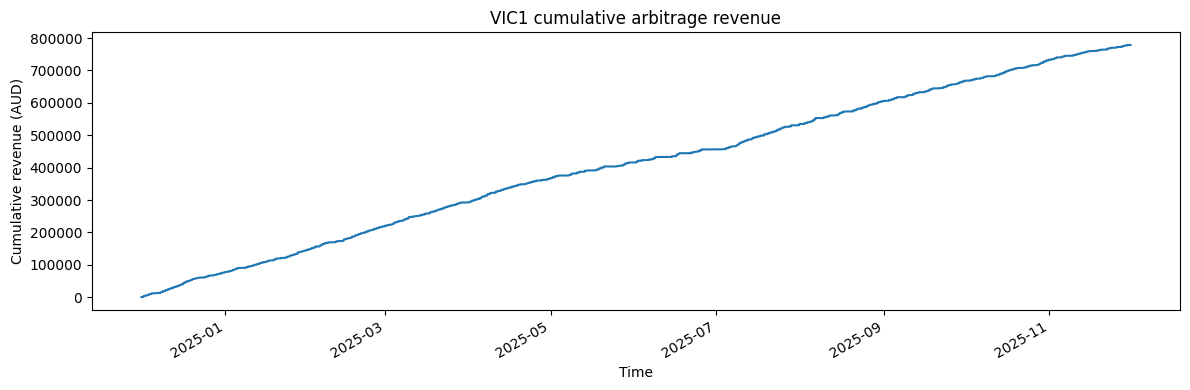

In [17]:
# plot cumulative revenue over the full simulation period

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(result_df.index, result_df["cumulative_revenue"])
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative revenue (AUD)")
ax.set_title(f"{region} cumulative arbitrage revenue")

fig.autofmt_xdate()
plt.tight_layout()
plt.show()
